In [7]:
import talib as ta
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

**Reading the data**

Columns description\
Open the open value for the stock in given day\
Close the close value for the stock in given day\
high the maxiumim value for the stock\
low the minimum vlaue for the stock\
volume the amount of shares 

In [2]:
data = pd.read_csv(r"C:\Users\ibrah\OneDrive\Desktop\AAPL.csv")

In [3]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400
...,...,...,...,...,...,...,...
9904,2020-03-26,246.520004,258.679993,246.360001,258.440002,258.440002,63021800
9905,2020-03-27,252.750000,255.869995,247.050003,247.740005,247.740005,51054200
9906,2020-03-30,250.740005,255.520004,249.399994,254.809998,254.809998,41994100
9907,2020-03-31,255.600006,262.489990,252.000000,254.289993,254.289993,49250500


**Analysis Stock Data**

1- Moving Avarge\
2- Exponintal moving avarage\

In [4]:
# take a copy from the data

data_copy = data.copy()


In [12]:
data_copy['SMA_close'] =  ta.SMA(data_copy['Close'],100)
data_copy['SMA_open'] =  ta.SMA(data_copy['Open'],100)



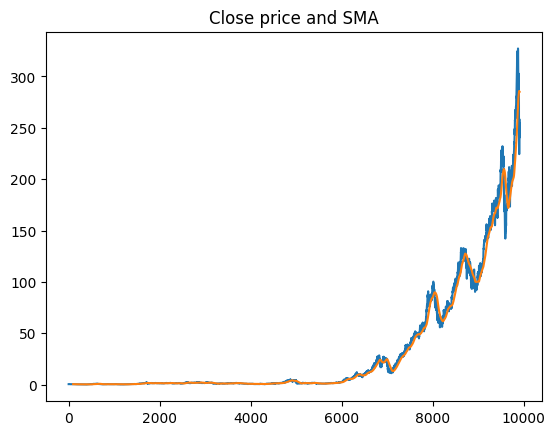

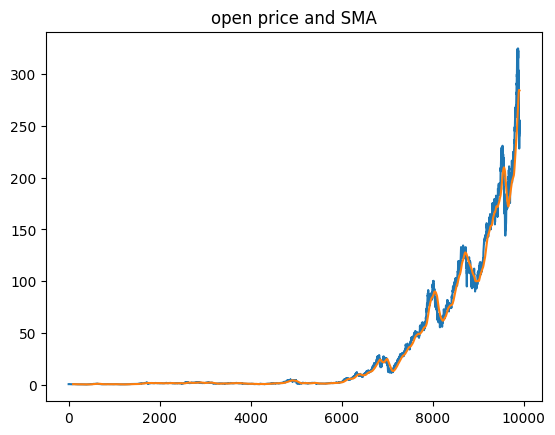

In [15]:
plt.plot(data_copy['Close'])
plt.plot(data_copy['SMA_close'])
plt.title("Close price and SMA")
plt.show()
plt.plot(data_copy['Open'])
plt.plot(data_copy['SMA_open'])
plt.title("open price and SMA")
plt.show()

In [16]:
data_copy['EMA_close'] = ta.EMA(data_copy['Close'],100)
data_copy['EMA_open'] = ta.EMA(data_copy['Open'],100)

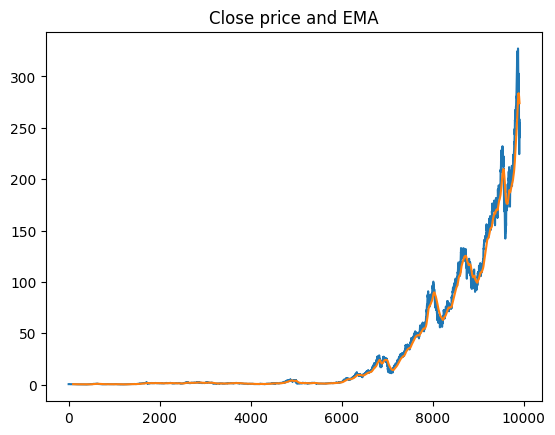

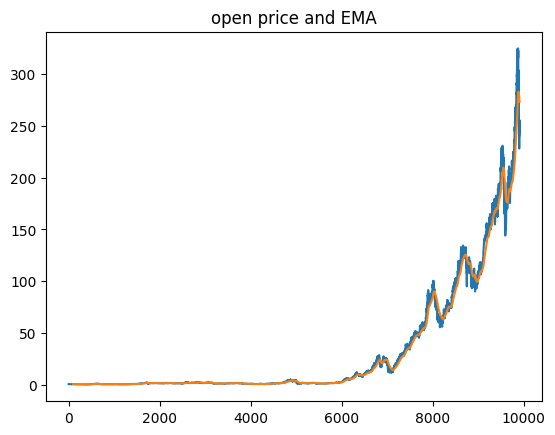

In [17]:
plt.plot(data_copy['Close'])
plt.plot(data_copy['EMA_close'])
plt.title("Close price and EMA")
plt.show()
plt.plot(data_copy['Open'])
plt.plot(data_copy['EMA_open'])
plt.title("open price and EMA")
plt.show()

## Convert data to timeseries form

In [22]:
data['Date'] = pd.to_datetime(data['Date'])
data.drop(['Open','Close','Volume','Adj Close'],axis=1,inplace=True)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9909 entries, 0 to 9908
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9909 non-null   datetime64[ns]
 1   High    9909 non-null   float64       
 2   Low     9909 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 232.4 KB


In [25]:
data['Low'] = data['Low'].astype('float64')
data['High'] = data['High'].astype('float64')

In [26]:
data.set_index("Date",inplace=True)

## EDA 

In [27]:
plt.style.use('ggplot')

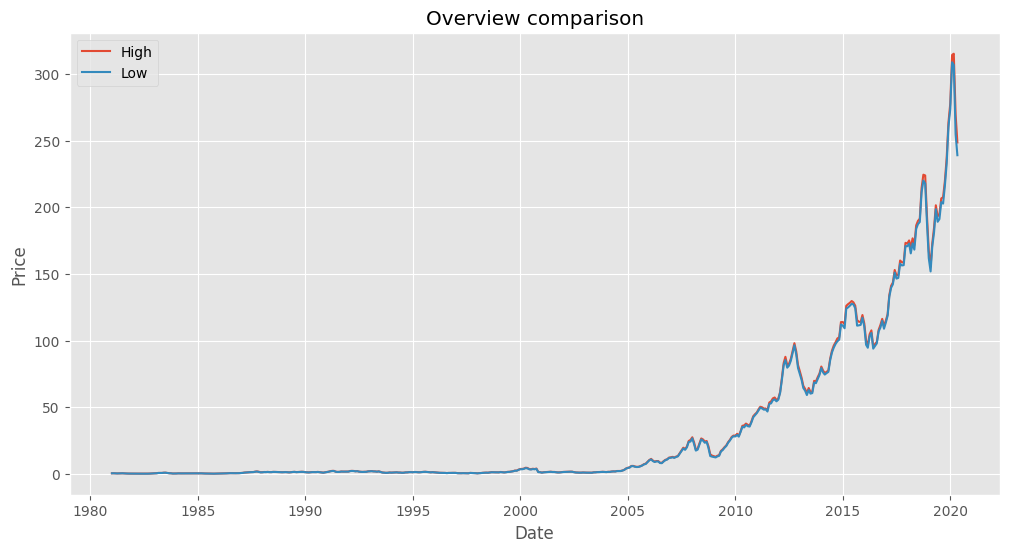

In [28]:
plt.figure(figsize=(12,6))
plt.title("Overview comparison")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(data.resample("m").mean())
plt.legend(data.columns)
plt.show()

## Yearly Comparison

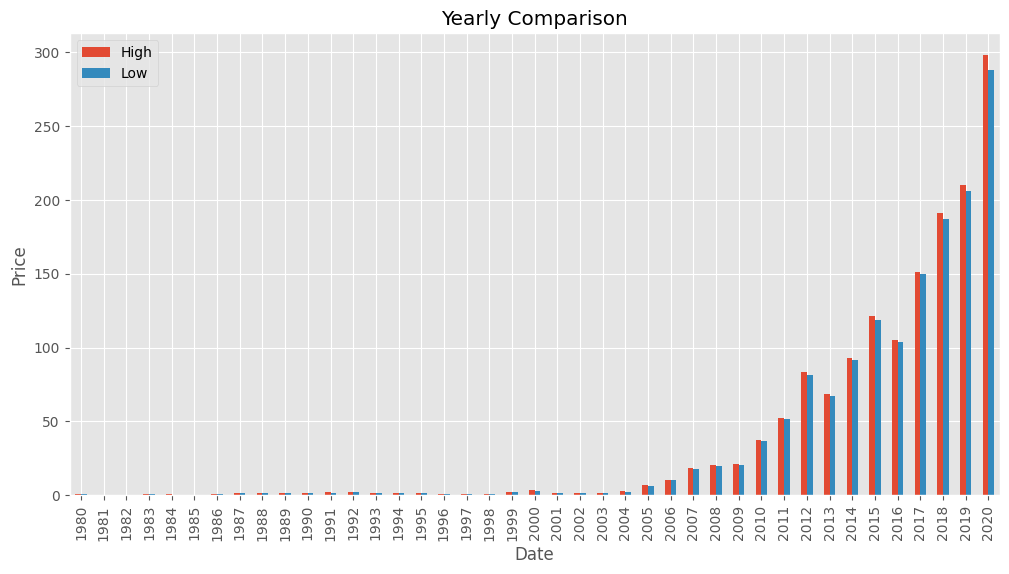

In [29]:
df_year = data.copy()
df_year['year'] = data.index.year
df_year = df_year.reset_index().drop('Date',axis=1).groupby('year').mean()
df_year.plot(kind='bar',figsize=(12,6),xlabel='Date',ylabel='Price',title='Yearly Comparison')
plt.show()

# Preprocessing

In [30]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
scalar_high = MinMaxScaler()
scalar_low = MinMaxScaler()

## Adjusting Data shape

In [31]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back+1):
        a = dataset.iloc[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back-1])
    return np.array(dataX), np.array(dataY)

## Train-val-test split

In [32]:
time_stamps = 20
train_size = round(len(data) * 0.7)
valid_size = round((len(data)-train_size)*0.7)
test_size = len(data) - (train_size+valid_size)
X_train, y_train = create_dataset(data[:train_size],time_stamps)
X_val, y_val = create_dataset(data[train_size:train_size+valid_size],time_stamps)
X_test, y_test = create_dataset(data[train_size+valid_size:],time_stamps)

In [33]:
X_train = X_train.astype(np.float64)
y_train = y_train.astype(np.float64)
X_val = X_val.astype(np.float64)
y_val = y_val.astype(np.float64)
X_test = X_test.astype(np.float64)
y_test = y_test.astype(np.float64)

In [34]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val", y_val.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (6917, 20, 2)
y_train:  (6917, 2)
X_val:  (2062, 20, 2)
y_val (2062, 2)
X_test:  (873, 20, 2)
y_test (873, 2)


In [35]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error
import tensorflow as tf
# The LSTM architecture
LSTM_model = Sequential()
# First LSTM layer with Dropout regularisation
LSTM_model.add(LSTM(units=32, return_sequences=True,activation='tanh', input_shape=(X_train.shape[1],X_train.shape[2])))
LSTM_model.add(Dropout(0.2))

LSTM_model.add(LSTM(units=64, return_sequences=True,activation='tanh'))
# LSTM_model.add(Dropout(0.2))

LSTM_model.add(LSTM(units=128, return_sequences=True,activation='tanh'))
LSTM_model.add(Dropout(0.2))

LSTM_model.add(LSTM(units=32,activation='tanh'))
# LSTM_model.add(Dropout(0.2))

LSTM_model.add(Dense(units=2))

LSTM_model.compile(optimizer='adam',loss='mean_absolute_error')

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True,
)

history = LSTM_model.fit(
    X_train,
    y_train,
    validation_data = (X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/100
109/109 [==============================] - 15s 37ms/step - loss: 1.3040 - val_loss: 60.7909
Epoch 2/100
109/109 [==============================] - 2s 18ms/step - loss: 0.7937 - val_loss: 58.1958
Epoch 3/100
109/109 [==============================] - 2s 18ms/step - loss: 0.6204 - val_loss: 56.2572
Epoch 4/100
109/109 [==============================] - 2s 17ms/step - loss: 0.5119 - val_loss: 54.6976
Epoch 5/100
109/109 [==============================] - 2s 17ms/step - loss: 0.4304 - val_loss: 53.4810
Epoch 6/100
109/109 [==============================] - 2s 18ms/step - loss: 0.3755 - val_loss: 52.1855
Epoch 7/100
109/109 [==============================] - 2s 17ms/step - loss: 0.3245 - val_loss: 50.8328
Epoch 8/100
109/109 [==============================] - 2s 18ms/step - loss: 0.2749 - val_loss: 49.6265
Epoch 9/100
109/109 [==============================] - 2s 17ms/step - loss: 0.2255 - val_loss: 48.7920
Epoch 10/100
109/109 [==============================] - 2s 18ms/step - l

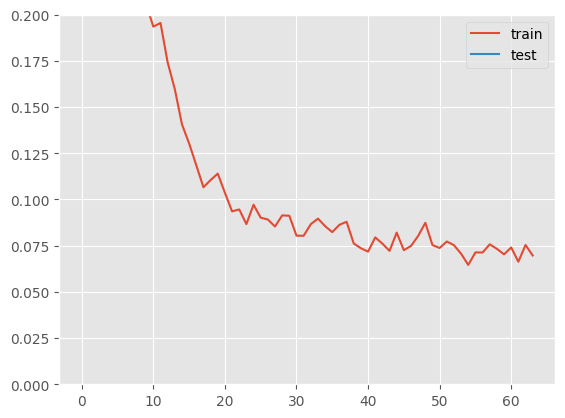

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.ylim(0,0.2)
plt.show()